# 1. Introduction

A brief description of your approach to the problem and the results that you 
have obtained on the training data.

\*Insert Introduction here\*

# 2. Data Import

This section is how you import the data into the notebook. It should be written in such 
a way that I can modify it to run on my own machine by simply changing the location 
of the training data and any additional data sources that you have used.

In [168]:
# I intend to use Data Frames to hold our data for now. When putting it in the model,
# I will probably have to change it to another format later but that is a problem for future me, not current me
# (Im joking; please dont deduct points, Mr/Ms Marker)
# Seriously though, Data Frames have very good performance and are malleable for data investigation,
# hence my decision to use them.

import pandas as pd
from pandas import DataFrame as df
import csv

def dataframe_from_diabetic_data_csv(csv_filepath):
    return pd.read_csv(csv_filepath)

TRAINING_DATA_FILEPATH = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/diabetic_data_training.csv"
TEST_DATA_FILEPATH = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/diabetic_data_test.csv"

training_data = dataframe_from_diabetic_data_csv(TRAINING_DATA_FILEPATH)
test_data = dataframe_from_diabetic_data_csv(TEST_DATA_FILEPATH)

print(training_data)



       encounter_id  patient_nbr             race  gender      age weight  \
0            149190     55629189        Caucasian  Female  [10-20)      ?   
1             64410     86047875  AfricanAmerican  Female  [20-30)      ?   
2            500364     82442376        Caucasian    Male  [30-40)      ?   
3             16680     42519267        Caucasian    Male  [40-50)      ?   
4             35754     82637451        Caucasian    Male  [50-60)      ?   
...             ...          ...              ...     ...      ...    ...   
91584     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
91585     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
91586     443854148     41088789        Caucasian    Male  [70-80)      ?   
91587     443857166     31693671        Caucasian  Female  [80-90)      ?   
91588     443867222    175429310        Caucasian    Male  [70-80)      ?   

       admission_type_id  discharge_disposition_id  admission_source_id  \


# 3. Data Transformation and Exploration
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [169]:
# Data transformations

# In this section, we create some helper functions that can help transform the data
# This includes cleaning the data. 
# Applying these functions results in better visualisations and insights into the data
# These functions can also be easily called for preprocessing before passing training data into model

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df = pd.read_csv(TRAINING_DATA_FILEPATH)

print(df.columns)

categorical_features = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id']
numerical_features = ['age_midpoint', 'number_inpatient', 'number_emergency', 'time_in_hospital']


def clean_inpatient_data(df):
    df = df.copy()

    cols = ["number_inpatient", "number_outpatient", "number_emergency"]

    df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

    # Replace NaN with 0 (patients often have no prior visits)
    df[cols] = df[cols].fillna(0)

    # Clip extreme outliers (very rare >10 visits)
    df[cols] = df[cols].clip(0, 10)

    df["total_visits"] = df["number_inpatient"] + df["number_outpatient"] + df["number_emergency"]

    df[cols + ["total_visits"]]
    return df

def clean_patient_interaction_cols(df):
    
    df = df.copy()

    encounter_cols = [
        "time_in_hospital",
        "admission_type_id",
        "discharge_disposition_id",
        "admission_source_id"
    ]

    # Convert to numeric
    df[encounter_cols] = df[encounter_cols].apply(pd.to_numeric, errors="coerce")

    # Replace any NaN with a special category (rare)
    df[["admission_type_id", "discharge_disposition_id", "admission_source_id"]] = \
        df[["admission_type_id", "discharge_disposition_id", "admission_source_id"]].fillna(-1)

    # Ensure time_in_hospital has no NaN
    df["time_in_hospital"] = df["time_in_hospital"].fillna(df["time_in_hospital"].median())

    return df

def standard_cleaning(df):
    #dropping na/invalid values
    df = df.copy()
    df = df[df['age_midpoint'].notna()]
    df = df[df['race'] != '?']
    df = df[df['gender'] != 'Unknown/Invalid']
    return df

def get_age_mid(row):
    row = row[1:-1]
    start, end = list(map(int, row.split("-")))
    return (start + end) / 2

def make_preprocessor():
    return ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
            ('num', StandardScaler(), numerical_features)
        ]
    )

df["age_midpoint"] = df["age"].apply(get_age_mid)

df = clean_inpatient_data(df)

df = clean_patient_interaction_cols(df)

df = standard_cleaning(df)

numerical_features.append("total_visits")


Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [170]:
# In the following sections we plot graphs that can visualise this cleaned data to get some insights into what fields are important for model building

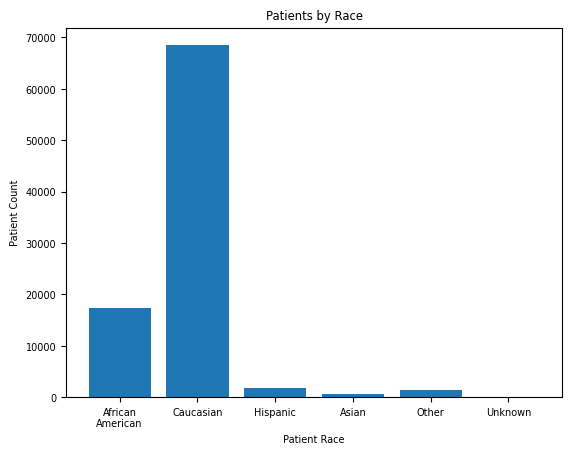

In [171]:
# Grouping by race to get some insights into frequency of patients by race
import seaborn as sns
from matplotlib import pyplot as plt

african_americans = df[df['race']=='AfricanAmerican']
african_american_patients = len(african_americans)

caucasians = df[df['race'] == 'Caucasian']
caucasian_patients = len(caucasians)

hispanics = df[df['race'] == 'Hispanic']
hispanic_patients = len(hispanics)

asians = df[df['race'] == 'Asian']
asian_patients = len(asians)

others = df[df['race'] == 'Other']
other_race_patients = len(others)

unknowns = df[df['race'] == '?']
unknown_race_patients = len(unknowns)

races = ['African\nAmerican', 'Caucasian', 'Hispanic', 'Asian', 'Other', 'Unknown']
patient_counts = [african_american_patients, caucasian_patients, hispanic_patients, asian_patients, other_race_patients, unknown_race_patients]

plt.bar(races, patient_counts)
plt.title("Patients by Race")
plt.xlabel("Patient Race")
plt.ylabel("Patient Count")
plt.show()


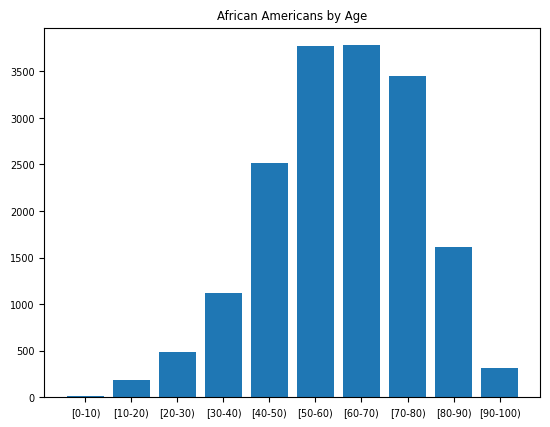

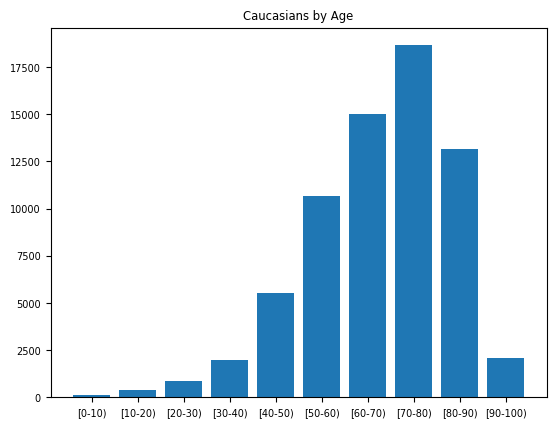

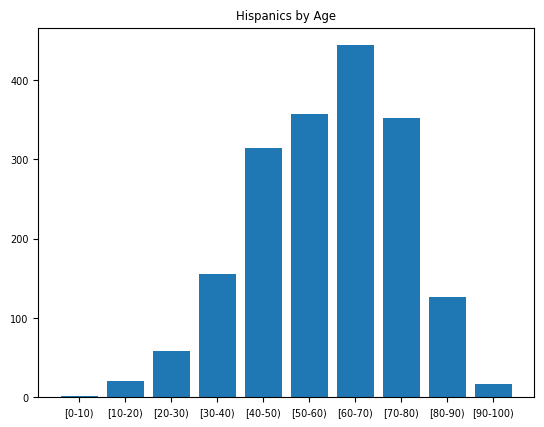

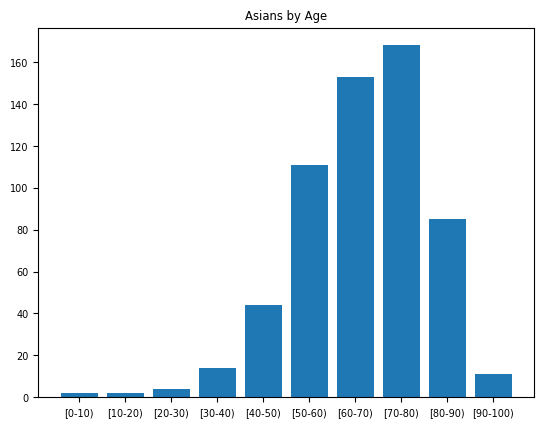

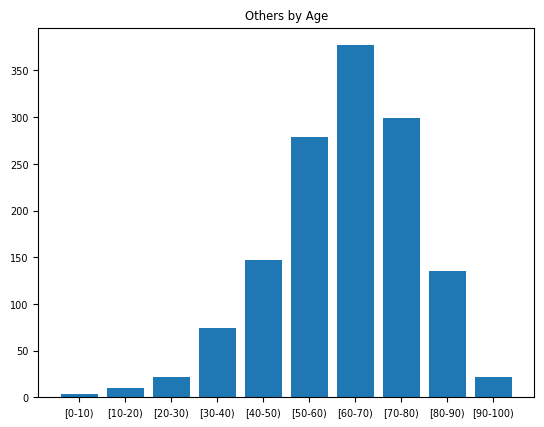

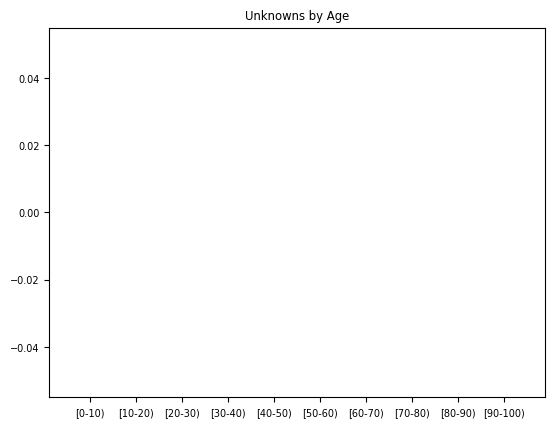

In [172]:
# Grouping patients by age within race
# '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)' '[80-90)' '[90-100)' '[0-10)'
age_brackets = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
african_americans_by_age = [len(african_americans[african_americans['age'] == bracket]) for bracket in age_brackets]
caucasians_by_age = [len(caucasians[caucasians['age'] == bracket]) for bracket in age_brackets]
hispanics_by_age = [len(hispanics[hispanics['age'] == bracket]) for bracket in age_brackets]
asians_by_age = [len(asians[asians['age'] == bracket]) for bracket in age_brackets]
others_by_age = [len(others[others['age'] == bracket]) for bracket in age_brackets]
unknowns_by_age = [len(unknowns[unknowns['age'] == bracket]) for bracket in age_brackets]

plt.rcParams.update({'font.size': 7})

plt.bar(age_brackets, african_americans_by_age)
plt.title('African Americans by Age')
plt.show()

plt.bar(age_brackets, caucasians_by_age)
plt.title('Caucasians by Age')
plt.show()

plt.bar(age_brackets, hispanics_by_age)
plt.title('Hispanics by Age')
plt.show()

plt.bar(age_brackets, asians_by_age)
plt.title('Asians by Age')
plt.show()

plt.bar(age_brackets, others_by_age)
plt.title('Others by Age')
plt.show()

plt.bar(age_brackets, unknowns_by_age)
plt.title('Unknowns by Age')
plt.show()

plt.rcParams.clear()


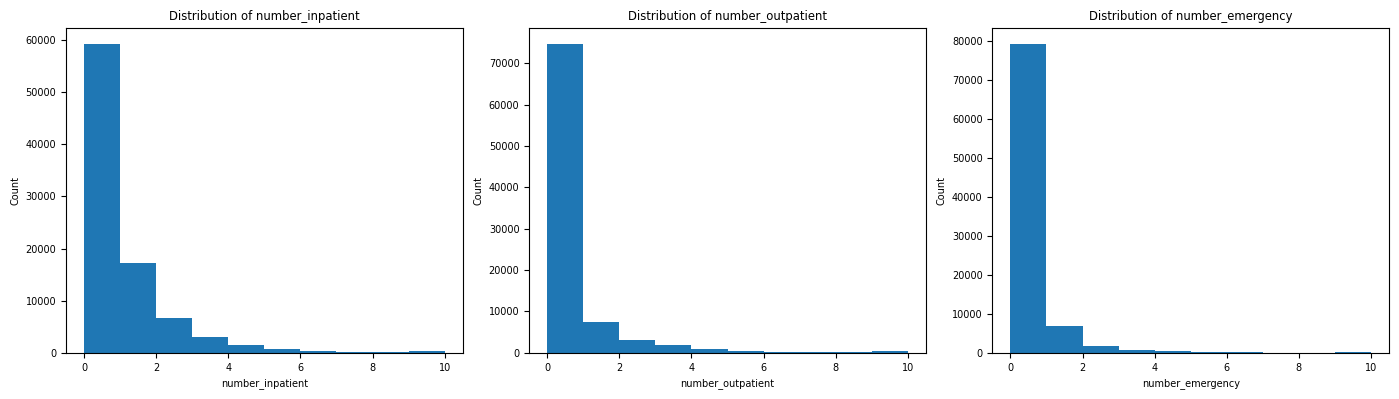

In [173]:

# understanding frequency and grouping of number_inpatient, number_outpatient and number_emergency

cols = ["number_inpatient", "number_outpatient", "number_emergency"]

plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    plt.hist(df[col], bins=10)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


/var/folders/2_/cs6k5z6129j71cv3p08t5vym0000gn/T/ipykernel_90304/757154414.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[cols], labels=cols)


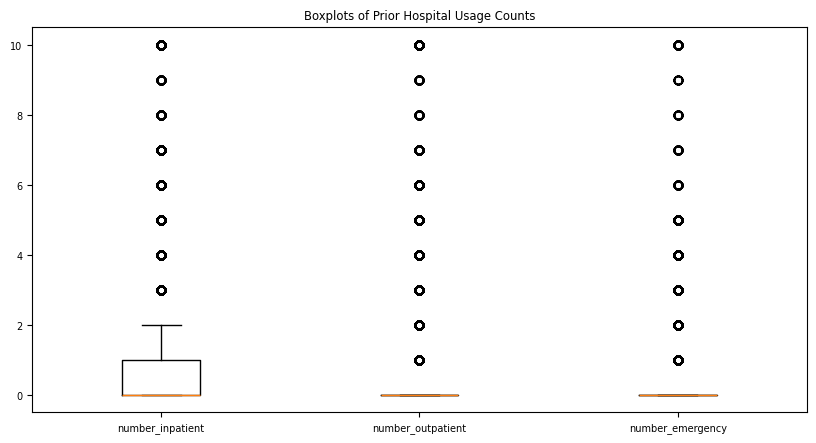

In [174]:
# understanding prior interaction with hospital after removing outliers
plt.figure(figsize=(10,5))
plt.boxplot(df[cols], labels=cols)
plt.title("Boxplots of Prior Hospital Usage Counts")
plt.show()


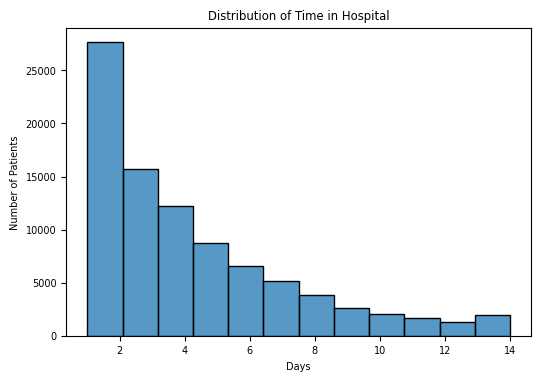

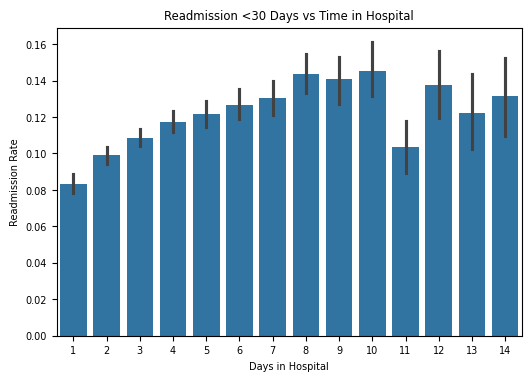

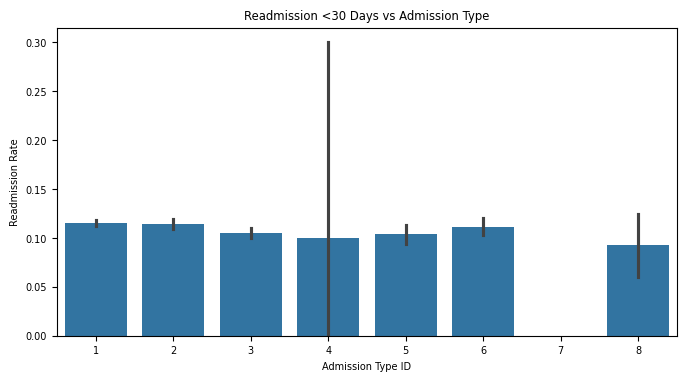

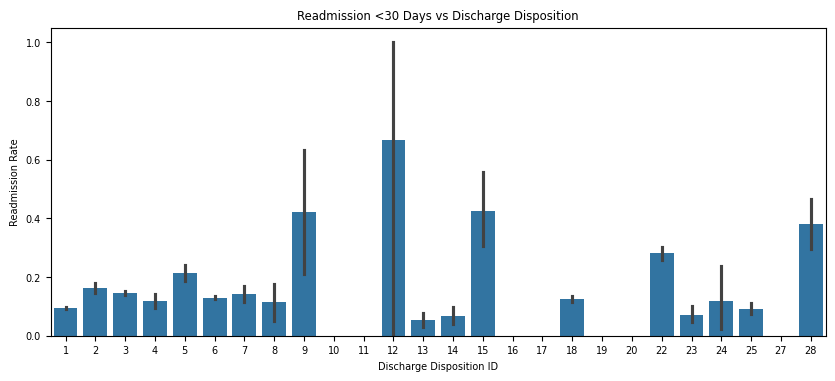

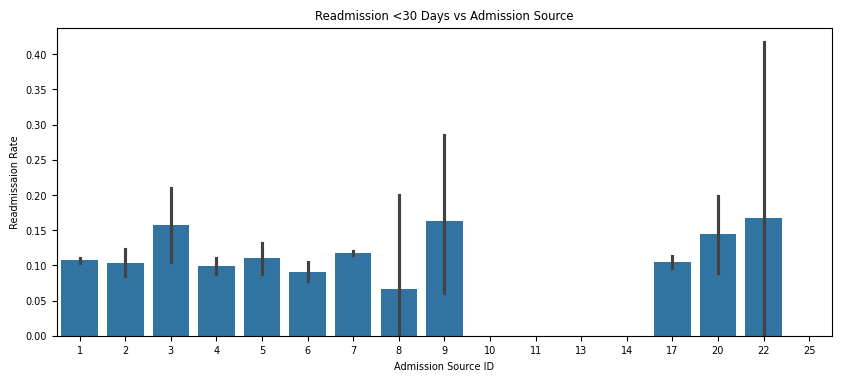

In [175]:
# plotting more fields regarding patient's prior interaction with hospital and their readmission rates
# this is to see which fields have some relationship to readmission

plt.figure(figsize=(6,4))
sns.histplot(df["time_in_hospital"], bins=12, kde=False)
plt.title("Distribution of Time in Hospital")
plt.xlabel("Days")
plt.ylabel("Number of Patients")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x=df["time_in_hospital"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Time in Hospital")
plt.xlabel("Days in Hospital")
plt.ylabel("Readmission Rate")
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x=df["admission_type_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Admission Type")
plt.xlabel("Admission Type ID")
plt.ylabel("Readmission Rate")
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x=df["discharge_disposition_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Discharge Disposition")
plt.xlabel("Discharge Disposition ID")
plt.ylabel("Readmission Rate")
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x=df["admission_source_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Admission Source")
plt.xlabel("Admission Source ID")
plt.ylabel("Readmissaion Rate")
plt.show()


In [176]:
# in this section we explore the relevance of features related to readmission to help choose the features on which to build the model

import numpy as np
from sklearn.model_selection import train_test_split

data = df.copy()

X = data[categorical_features + numerical_features]
y = data["readmitted"]

preprocessor = make_preprocessor()
X_processed = preprocessor.fit_transform(X)

feature_names_cat = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
feature_names_num = numerical_features
feature_names = np.concatenate([feature_names_cat, feature_names_num])

X_dense = X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_dense, y, test_size=0.2, stratify=y, random_state=42
)


In [177]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train, y_train, random_state=42)

mi_df = pd.DataFrame({
    "feature": feature_names,
    "mutual_information": mi
}).sort_values("mutual_information", ascending=False)

mi_df.head(30)



,feature,mutual_information
42,number_inpatient,0.034916
45,total_visits,0.032863
43,number_emergency,0.010723
15,discharge_disposition_id_1,0.010369
2,race_Caucasian,0.007456
25,discharge_disposition_id_11,0.006869
31,discharge_disposition_id_17,0.004454
4,race_Other,0.004365
5,gender_Female,0.004119
30,discharge_disposition_id_16,0.003090


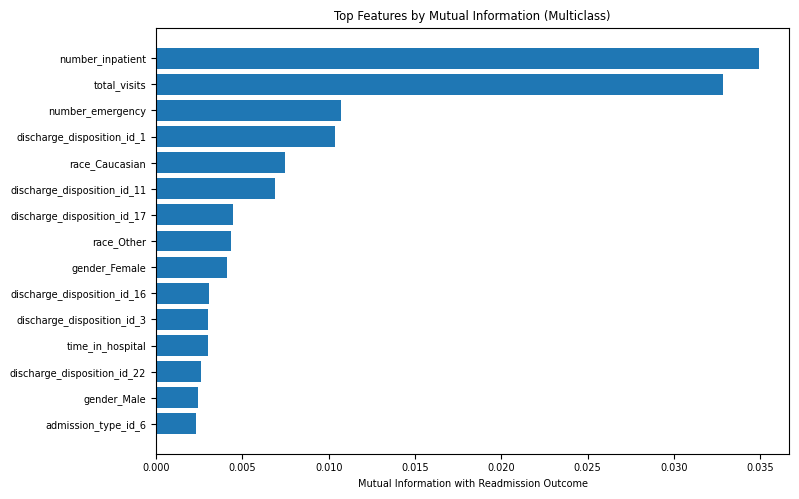

In [178]:
import matplotlib.pyplot as plt

top_n = 15
top_mi = mi_df.head(top_n)

plt.figure(figsize=(8, 5))
plt.barh(top_mi["feature"], top_mi["mutual_information"])
plt.gca().invert_yaxis()  # highest at top
plt.xlabel("Mutual Information with Readmission Outcome")
plt.title("Top Features by Mutual Information (Multiclass)")
plt.tight_layout()
plt.show()


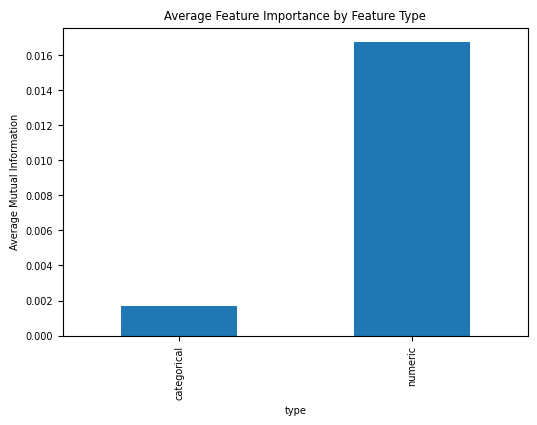

In [179]:
mi_df["type"] = mi_df["feature"].apply(
    lambda x: "numeric" if x in numerical_features else "categorical"
)

plt.figure(figsize=(6,4))
mi_df.groupby("type")["mutual_information"].mean().plot(kind="bar")
plt.ylabel("Average Mutual Information")
plt.title("Average Feature Importance by Feature Type")
plt.show()


In [180]:
# Lasso regression model to understand most important features
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

lasso = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.5,              # smaller = stronger feature selection
    max_iter=5000,
    random_state=42
)

lasso.fit(X_dense, y)

# coefficients shape: (n_classes, n_features)
coef = lasso.coef_

# average absolute weight across classes
mean_abs_coef = np.mean(np.abs(coef), axis=0)

lasso_df = pd.DataFrame({
    "feature": feature_names,
    "importance": mean_abs_coef
}).sort_values("importance", ascending=False)

# selected features (non-zero)
selected_df = lasso_df[lasso_df["importance"] > 0]

print("Total features:", len(feature_names))
print("Selected by LASSO:", selected_df.shape[0])

selected_df.head(15)


/Users/varunsrinivasan/Documents/University/Year 3/Data Mining & Analysis/BENG0095CW/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/varunsrinivasan/Documents/University/Year 3/Data Mining & Analysis/BENG0095CW/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Total features: 46
Selected by LASSO: 37


,feature,importance
25,discharge_disposition_id_11,2.298475
28,discharge_disposition_id_14,1.130198
27,discharge_disposition_id_13,0.650047
13,admission_type_id_7,0.484590
40,discharge_disposition_id_28,0.470606
29,discharge_disposition_id_15,0.468471
23,discharge_disposition_id_9,0.357847
35,discharge_disposition_id_22,0.342340
36,discharge_disposition_id_23,0.256031
19,discharge_disposition_id_5,0.226590


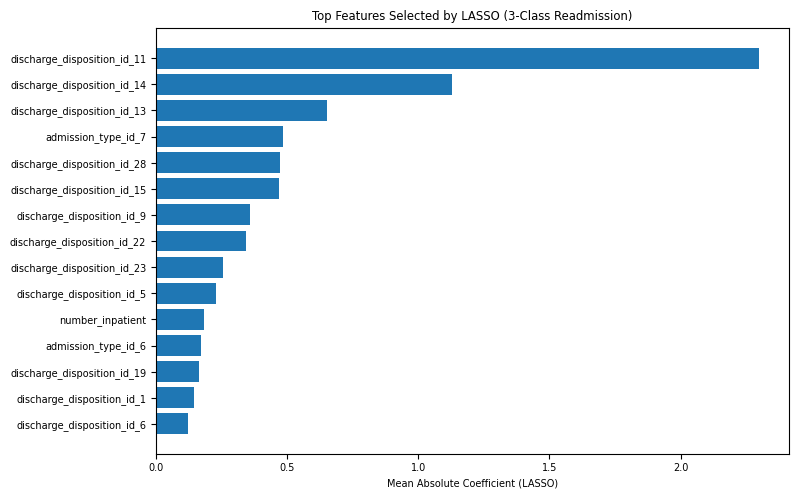

In [181]:
import matplotlib.pyplot as plt

top_n = 15
top_lasso = lasso_df.head(top_n)

plt.figure(figsize=(8,5))
plt.barh(top_lasso["feature"], top_lasso["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Mean Absolute Coefficient (LASSO)")
plt.title("Top Features Selected by LASSO (3-Class Readmission)")
plt.tight_layout()
plt.show()

In [182]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

ridge = LogisticRegression(
    penalty="l2",       # Ridge
    solver="lbfgs",
    C=1.0,              # smaller = stronger regularisation
    max_iter=5000,
    random_state=42
)

ridge.fit(X_dense, y)

coef = ridge.coef_    # shape: (n_classes, n_features)

mean_abs_coef = np.mean(np.abs(coef), axis=0)

ridge_df = pd.DataFrame({
    "feature": feature_names,
    "importance": mean_abs_coef
}).sort_values("importance", ascending=False)

ridge_df.head(15)


/Users/varunsrinivasan/Documents/University/Year 3/Data Mining & Analysis/BENG0095CW/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,feature,importance
25,discharge_disposition_id_11,2.645513
28,discharge_disposition_id_14,0.943519
40,discharge_disposition_id_28,0.650855
27,discharge_disposition_id_13,0.634045
29,discharge_disposition_id_15,0.599362
35,discharge_disposition_id_22,0.440555
36,discharge_disposition_id_23,0.375278
19,discharge_disposition_id_5,0.345263
13,admission_type_id_7,0.344310
20,discharge_disposition_id_6,0.327821


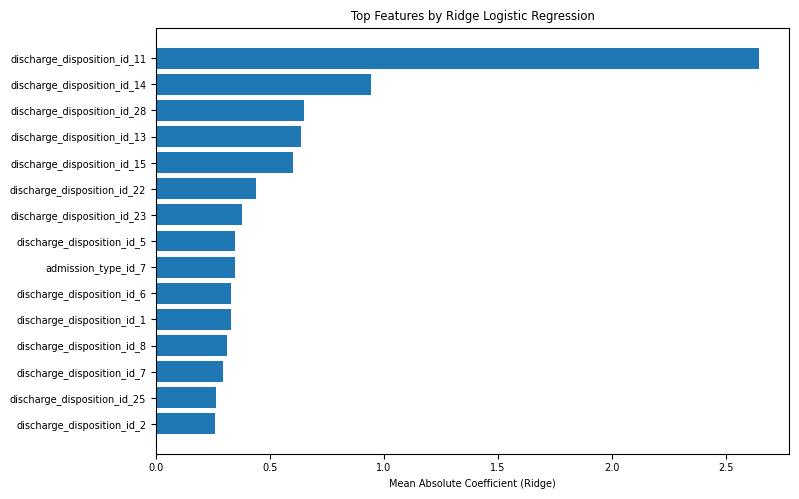

In [183]:
import matplotlib.pyplot as plt

top_n = 15
top_ridge = ridge_df.head(top_n)

plt.figure(figsize=(8,5))
plt.barh(top_ridge["feature"], top_ridge["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Mean Absolute Coefficient (Ridge)")
plt.title("Top Features by Ridge Logistic Regression")
plt.tight_layout()
plt.show()


# 4. Methodology Overview
Code for the equivalent section in your report, together with in-line documentation of 
that code.

# 5. Model Training & Validation
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [184]:
# Binary classifier neural network

## Using: 'race','gender','age', 'admission_type_id','discharge_disposition_id'
##        'number_inpatient','number_emergency','time_in_hospital'

# Predicting: readmitted

import pandas as pd

df_binary_nn = df.copy()
df_binary_nn["readmit_binary"]=(df_binary_nn["readmitted"] != 'NO').astype(int)
X = df_binary_nn[categorical_features + numerical_features]
y = df_binary_nn["readmit_binary"]
preprocessor = make_preprocessor()
X_processed = preprocessor.fit_transform(X)
X_dense = X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_dense, y, test_size=0.2, random_state=42, stratify=y
)

In [185]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_nn, y_train_nn)

print("Before SMOTE:", np.bincount(y_train_nn))
print("After SMOTE:", np.bincount(y_train_res))

# Define model
binary_nn_model = Sequential([
    Dense(32, activation="relu", input_shape=(X_train_res.shape[1],)),
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(4, activation="relu"),
    Dense(1, activation="sigmoid")
])

binary_nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train on resampled data
history = binary_nn_model.fit(
    X_train_res, y_train_res,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)


Before SMOTE: [38365 33258]
After SMOTE: [38365 38365]
Epoch 1/20


/Users/varunsrinivasan/Documents/University/Year 3/Data Mining & Analysis/BENG0095CW/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1919/1919 ━━━━━━━━━━━━━━━━━━━━ 2s 547us/step - accuracy: 0.6179 - loss: 0.6581 - val_accuracy: 0.5575 - val_loss: 0.6735
Epoch 2/20
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.6291 - loss: 0.6448 - val_accuracy: 0.5956 - val_loss: 0.6488
Epoch 3/20
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - accuracy: 0.6309 - loss: 0.6417 - val_accuracy: 0.5704 - val_loss: 0.6734
Epoch 4/20
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6299 - loss: 0.6402 - val_accuracy: 0.5819 - val_loss: 0.6628
Epoch 5/20
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6309 - loss: 0.6388 - val_accuracy: 0.5738 - val_loss: 0.6664
Epoch 6/20
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6323 - loss: 0.6379 - val_accuracy: 0.5758 - val_loss: 0.6717
Epoch 7/20
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - accuracy: 0.6327 - loss: 0.6371 - val_accuracy: 0.5988 - val_loss: 0.6500
Epoch 8/20
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step - accuracy: 0.6346 - loss: 0.63

In [186]:
# 3 way logistic regression model

import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

train_df = df.copy()

features = categorical_features + numerical_features

X_train_log_reg = train_df[features]
y_train_log_reg = train_df['readmitted']

label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train_log_reg)


In [187]:
# fitting regression model to the training data
# Pipeline ties preprocessing and model training together
# Apply SMOTE to training
log_reg_model = Pipeline(steps=[
    ('preprocessor', make_preprocessor()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(
        solver='lbfgs',
        max_iter=1000
    ))
])

# remove smote to evaluate impact of smote later
log_reg_model_no_smote = Pipeline(steps=[
    ('preprocessor', make_preprocessor()),
    ('classifier', LogisticRegression(
        solver='lbfgs',
        max_iter=1000
    ))
])

# Fit the multi-class logistic regression model
log_reg_model.fit(X_train_log_reg, y_train_enc)
log_reg_model_no_smote.fit(X_train_log_reg, y_train_enc)

y_pred_log_reg = log_reg_model.predict(X_train_log_reg)
y_pred_log_reg_no_smote = log_reg_model_no_smote.predict(X_train_log_reg)


In [188]:
# Kernel SVM for 3-way classification

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import pandas as pd

train_df = df.copy()

# Kernel SVMs are expensive to train.
# To reduce training time, randomly sample 30% of the training data.
train_df = train_df.sample(frac=0.3, random_state=42)

features = categorical_features + numerical_features

# Input features
X_train_svm = train_df[features]

# Target variable (3-way readmission classification)
y_train_svm = train_df['readmitted']

# Build SVM pipeline with SMOTE
svm_model = Pipeline(steps=[
    ('preprocessor', make_preprocessor()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(
        kernel='rbf',                  
        gamma='scale',                 
        decision_function_shape='ovr', 
        C=1.0,                         
        cache_size=500,                
        verbose=1 
    ))
])

svm_model_no_smote = Pipeline(steps=[
    ('preprocessor', make_preprocessor()),
    ('classifier', SVC(
        kernel='rbf',                  
        gamma='scale',                 
        decision_function_shape='ovr', 
        C=1.0,                         
        cache_size=500,                
        verbose=1 
    ))
])

# Model training and fitting
# Train on the sampled subset for speed
svm_model.fit(X_train_svm, y_train_svm)
svm_model_no_smote.fit(X_train_svm, y_train_svm)

# Predict class labels on the training set
y_train_pred_svm = svm_model.predict(X_train_svm)
y_train_pred_svm_no_smote = svm_model_no_smote.predict(X_train_svm)


[LibSVM]...................
*........*
optimization finished, #iter = 27323
obj = -22232.306116, rho = 2.808450
nSV = 23864, nBSV = 23132
........................
*.............
*.
*
optimization finished, #iter = 37568
obj = -18885.265945, rho = 2.537516
nSV = 20223, nBSV = 19254
.......................
*..............
*..*
optimization finished, #iter = 39119
obj = -22096.516072, rho = 0.316772
nSV = 23115, nBSV = 22002
Total nSV = 39309
[LibSVM]..................
*...................................................
*..
*
optimization finished, #iter = 71191
obj = -5809.344698, rho = 0.718094
nSV = 7171, nBSV = 4983
..................
*..........................................................
*....
*
optimization finished, #iter = 80062
obj = -5658.071800, rho = 0.241923
nSV = 7193, nBSV = 4833
.......................
*...............................................
*...
*
optimization finished, #iter = 72964
obj = -16692.699051, rho = -0.242440
nSV = 17794, nBSV = 16235
Total nSV =

In [190]:
# Naive Bayes (3-way classification) using helper preprocessing
# NEED TO APPLY SMOTE
from sklearn.naive_bayes import GaussianNB

# Reuse helper feature lists so preprocessing is consistent
features_nb = categorical_features + numerical_features
X_train_nb = df[features_nb]
y_train_nb = df["readmitted"]

nb_preprocessor = make_preprocessor()
# GaussianNB expects dense numeric input
X_train_nb_proc = nb_preprocessor.fit_transform(X_train_nb)
if hasattr(X_train_nb_proc, "toarray"):
    X_train_nb_proc = X_train_nb_proc.toarray()

# Train a simple generative baseline for 3-class prediction
nb_model = GaussianNB()
nb_model.fit(X_train_nb_proc, y_train_nb)


,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


In [191]:
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

features_mlp = categorical_features + numerical_features
X_train_mlp = df[features_mlp]
y_train_mlp = df["readmitted"]

mlp_preprocessor = make_preprocessor()
X_train_mlp_proc = mlp_preprocessor.fit_transform(X_train_mlp)
if hasattr(X_train_mlp_proc, "toarray"):
    X_train_mlp_proc = X_train_mlp_proc.toarray()

smote = SMOTE(random_state=42)
X_train_mlp_res, y_train_mlp_res = smote.fit_resample(X_train_mlp_proc, y_train_mlp)

print("Before SMOTE:\n", y_train_mlp.value_counts())
print("\nAfter SMOTE:\n", pd.Series(y_train_mlp_res).value_counts())

# MLP model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=200,
    random_state=42,
)

mlp_model.fit(X_train_mlp_res, y_train_mlp_res)

mlp_model_no_smote = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=200,
    random_state=42,
)

mlp_model_no_smote.fit(X_train_mlp_proc, y_train_mlp)


Before SMOTE:
 readmitted
NO     47957
>30    31496
<30    10076
Name: count, dtype: int64

After SMOTE:
 readmitted
>30    47957
NO     47957
<30    47957
Name: count, dtype: int64


/Users/varunsrinivasan/Documents/University/Year 3/Data Mining & Analysis/BENG0095CW/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/varunsrinivasan/Documents/University/Year 3/Data Mining & Analysis/BENG0095CW/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(64, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.For an example usage and visualization of varying regularization, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_alpha.py`.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the classifier will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",'auto'
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when ``solver='sgd'``.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.001
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",200
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True
,"random_state random_state: int, RandomState instance, default=NoneDetermines random number generation for weights and biasinitialization, train-test split if early stopping is used, and batchsampling when solver='sgd' or 'adam'.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42


In [146]:
# Two-stage model: Naive Bayes for readmitted vs NO, SVM for <30 vs >30
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import FunctionTransformer

features_two_stage = categorical_features + numerical_features
X_two_stage = df[features_two_stage]
y_two_stage = df["readmitted"]

# GaussianNB requires dense input, so convert after preprocessing
to_dense = FunctionTransformer(
    lambda x: x.toarray() if hasattr(x, "toarray") else x,
    accept_sparse=True,
)
# Stage 1: binary readmission gate (YES/NO)
stage1_nb = Pipeline(steps=[
    ("preprocessor", make_preprocessor()),
    ("to_dense", to_dense),
    ("smote", SMOTE(random_state=42)),
    ("classifier", GaussianNB()),
])

# same pipeline without smote
stage1_nb_no_smote = Pipeline(steps=[
    ("preprocessor", make_preprocessor()),
    ("to_dense", to_dense),
    ("classifier", GaussianNB()),
])

y1_full = (y_two_stage != "NO").astype(int)
stage1_nb.fit(X_two_stage, y1_full)
stage1_nb_no_smote.fit(X_two_stage, y1_full)

# Stage 2: only predict <30 vs >30 for readmitted patients
stage2_svm = Pipeline(steps=[
    ("preprocessor", make_preprocessor()),
    ("smote", SMOTE(random_state=42)),
    ("classifier", SVC(
        kernel="rbf",
        gamma="scale",
        decision_function_shape="ovr",
        C=1.0,
        cache_size=500,
    )),
])


stage2_svm_no_smote = Pipeline(steps=[
    ("preprocessor", make_preprocessor()),
    ("smote", SMOTE(random_state=42)),
    ("classifier", SVC(
        kernel="rbf",
        gamma="scale",
        decision_function_shape="ovr",
        C=1.0,
        cache_size=500,
    )),
])


readmit_mask_full = y_two_stage != "NO"
# If training is too slow, sample the readmitted subset here.
# readmit_sample = X_two_stage[readmit_mask_full].sample(frac=0.3, random_state=42)
# y_readmit_sample = y_two_stage[readmit_mask_full].loc[readmit_sample.index]
# stage2_svm.fit(readmit_sample, y_readmit_sample)

stage2_svm.fit(X_two_stage[readmit_mask_full], y_two_stage[readmit_mask_full])
stage2_svm_no_smote.fit(X_two_stage[readmit_mask_full], y_two_stage[readmit_mask_full])


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The

# 6. Results
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [88]:
# inference of the binary neural network on the training dataset
from sklearn.metrics import accuracy_score, classification_report

# Predict probabilities on training data
y_train_prob = binary_nn_model.predict(X_train_nn)

# Convert probabilities to class labels (0/1)
y_train_pred = (y_train_prob > 0.5).astype("int32").ravel()

# Evaluation on training data
print("Training Accuracy:", accuracy_score(y_train_nn, y_train_pred))
print("Training Classification Report:")
print(classification_report(y_train_nn, y_train_pred))


2239/2239 ━━━━━━━━━━━━━━━━━━━━ 1s 219us/step
Training Accuracy: 0.6379794200187091
Training Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.75      0.69     38365
           1       0.64      0.51      0.57     33258

    accuracy                           0.64     71623
   macro avg       0.64      0.63      0.63     71623
weighted avg       0.64      0.64      0.63     71623



In [129]:
# inference of logistic regression model on the training data
print("Accuracy:", accuracy_score(y_train_enc, y_pred_log_reg))
print(classification_report(
    y_train_enc,
    y_pred_log_reg,
    target_names=label_encoder.classes_
))


Accuracy: 0.5011002021691295
              precision    recall  f1-score   support

         <30       0.20      0.40      0.27     10076
         >30       0.45      0.32      0.38     31496
          NO       0.65      0.64      0.64     47957

    accuracy                           0.50     89529
   macro avg       0.43      0.45      0.43     89529
weighted avg       0.53      0.50      0.51     89529



In [131]:

# inference of logistic regression model on the training data for non smote
print("Accuracy:", accuracy_score(y_train_enc, y_pred_log_reg_no_smote))
print(classification_report(
    y_train_enc,
    y_pred_log_reg_no_smote,
    target_names=label_encoder.classes_
))


Accuracy: 0.5739481062002256
              precision    recall  f1-score   support

         <30       0.39      0.02      0.04     10076
         >30       0.51      0.26      0.34     31496
          NO       0.59      0.90      0.71     47957

    accuracy                           0.57     89529
   macro avg       0.50      0.39      0.36     89529
weighted avg       0.54      0.57      0.51     89529



In [132]:
# Inference of Kernel SVM model on training data
from sklearn.metrics import accuracy_score, classification_report
print("SVM Model Training Results:")
print("Accuracy:", accuracy_score(y_train_svm, y_train_pred_svm))
print("\nClassification Report:")
print(classification_report(
    y_train_svm,
    y_train_pred_svm,
    target_names=label_encoder.classes_
))


SVM Model Training Results:
Accuracy: 0.5190066644327785

Classification Report:
              precision    recall  f1-score   support

         <30       0.22      0.51      0.31      2986
         >30       0.52      0.38      0.44      9465
          NO       0.67      0.62      0.64     14408

    accuracy                           0.52     26859
   macro avg       0.47      0.50      0.46     26859
weighted avg       0.57      0.52      0.53     26859



In [133]:

# Inference of Kernel SVM model on training data without smote
from sklearn.metrics import accuracy_score, classification_report
print("SVM Model Training Results:")
print("Accuracy:", accuracy_score(y_train_svm, y_train_pred_svm_no_smote))
print("\nClassification Report:")
print(classification_report(
    y_train_svm,
    y_train_pred_svm_no_smote,
    target_names=['Not Readmitted', 'Readmitted >30 Days', 'Readmitted <30 Days']
))


SVM Model Training Results:
Accuracy: 0.5923154249972077

Classification Report:
                     precision    recall  f1-score   support

     Not Readmitted       0.85      0.02      0.04      2986
Readmitted >30 Days       0.54      0.33      0.41      9465
Readmitted <30 Days       0.61      0.88      0.72     14408

           accuracy                           0.59     26859
          macro avg       0.67      0.41      0.39     26859
       weighted avg       0.61      0.59      0.53     26859



In [118]:
# Inference of Naive Bayes model on training data
from sklearn.metrics import accuracy_score, classification_report

labels_nb = ["NO", ">30", "<30"]

y_train_pred_nb = nb_model.predict(X_train_nb_proc)

print("Naive Bayes Training Results:")
print("Accuracy:", accuracy_score(y_train_nb, y_train_pred_nb))
print(classification_report(
    y_train_nb,
    y_train_pred_nb,
    labels=labels_nb,
    target_names=labels_nb
))


Naive Bayes Training Results:
Accuracy: 0.14056273133236524
              precision    recall  f1-score   support

          NO       0.93      0.05      0.09     49355
         >30       0.38      0.02      0.03     31989
         <30       0.11      0.98      0.21     10245

    accuracy                           0.14     91589
   macro avg       0.48      0.35      0.11     91589
weighted avg       0.65      0.14      0.08     91589



In [144]:
# Inference of MLP model on training data
from sklearn.metrics import accuracy_score, classification_report

labels_mlp = ["NO", ">30", "<30"]

y_train_pred_mlp = mlp_model.predict(X_train_mlp_proc)
y_train_pred_mlp_no = mlp_model_no_smote.predict(X_train_mlp_proc)

print("MLP + SMOTE — Training Results")
print("Accuracy:", accuracy_score(y_train_mlp, y_train_pred_mlp))
print(classification_report(
    y_train_mlp,
    y_train_pred_mlp,
    labels=labels_mlp,
    target_names=labels_mlp,
    zero_division=0
))

print("MLP NO SMOTE — Training Results")
print("Accuracy:", accuracy_score(y_train_mlp, y_train_pred_mlp_no))
print(classification_report(
    y_train_mlp,
    y_train_pred_mlp_no,
    labels=labels_mlp,
    target_names=labels_mlp,
    zero_division=0
))


MLP + SMOTE — Training Results
Accuracy: 0.5312245194294586
              precision    recall  f1-score   support

          NO       0.67      0.60      0.63     47957
         >30       0.48      0.44      0.46     31496
         <30       0.27      0.47      0.34     10076

    accuracy                           0.53     89529
   macro avg       0.47      0.50      0.48     89529
weighted avg       0.56      0.53      0.54     89529

MLP NO SMOTE — Training Results
Accuracy: 0.5987333713098549
              precision    recall  f1-score   support

          NO       0.61      0.88      0.72     47957
         >30       0.56      0.33      0.41     31496
         <30       0.56      0.09      0.15     10076

    accuracy                           0.60     89529
   macro avg       0.58      0.43      0.43     89529
weighted avg       0.59      0.60      0.55     89529



In [147]:
# Two-stage model training results (NB -> SVM)
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Stage 1 evaluation
y1_pred_full = stage1_nb.predict(X_two_stage)
print("Two-stage Stage 1 (NB): Readmitted vs NO")
print("Accuracy:", accuracy_score(y1_full, y1_pred_full))
print(classification_report(
    y1_full,
    y1_pred_full,
    target_names=["NO", "Readmitted"],
    zero_division=0,
))

# Stage 2 evaluation on true readmitted subset
y2_true = y_two_stage[readmit_mask_full]
y2_pred = stage2_svm.predict(X_two_stage[readmit_mask_full])
print("Two-stage Stage 2 (SVM): <30 vs >30")
print("Accuracy:", accuracy_score(y2_true, y2_pred))
print(classification_report(
    y2_true,
    y2_pred,
    labels=[">30", "<30"],
    target_names=[">30", "<30"],
    zero_division=0,
))

# Combined 3-class prediction
final_pred = np.array(["NO"] * len(y_two_stage), dtype=object)
readmit_pred_mask = y1_pred_full == 1
if readmit_pred_mask.any():
    final_pred[readmit_pred_mask] = stage2_svm.predict(X_two_stage[readmit_pred_mask])

print("Two-stage combined (3-class)")
print("Accuracy:", accuracy_score(y_two_stage, final_pred))
print(classification_report(
    y_two_stage,
    final_pred,
    labels=["NO", ">30", "<30"],
    target_names=["NO", ">30", "<30"],
    zero_division=0,
))


Two-stage Stage 1 (NB): Readmitted vs NO
Accuracy: 0.4895732109148991
              precision    recall  f1-score   support

          NO       0.86      0.06      0.11     47957
  Readmitted       0.48      0.99      0.64     41572

    accuracy                           0.49     89529
   macro avg       0.67      0.52      0.37     89529
weighted avg       0.68      0.49      0.35     89529

Two-stage Stage 2 (SVM): <30 vs >30
Accuracy: 0.6599153276243626
              precision    recall  f1-score   support

         >30       0.82      0.71      0.76     31496
         <30       0.36      0.50      0.42     10076

    accuracy                           0.66     41572
   macro avg       0.59      0.60      0.59     41572
weighted avg       0.70      0.66      0.68     41572

Two-stage combined (3-class)
Accuracy: 0.332964737682762
              precision    recall  f1-score   support

          NO       0.86      0.06      0.11     47957
         >30       0.37      0.70      0.48  

In [148]:
# Stage 1 evaluation (NO SMOTE)
y1_pred_full_no = stage1_nb_no_smote.predict(X_two_stage)

print("Two-stage Stage 1 (NB) — NO SMOTE: Readmitted vs NO")
print("Accuracy:", accuracy_score(y1_full, y1_pred_full_no))
print(classification_report(
    y1_full,
    y1_pred_full_no,
    target_names=["NO", "Readmitted"],
    zero_division=0,
))

# Stage 2 evaluation (NO SMOTE)
y2_true_no = y_two_stage[readmit_mask_full]
y2_pred_no = stage2_svm_no_smote.predict(X_two_stage[readmit_mask_full])

print("Two-stage Stage 2 (SVM) — NO SMOTE: <30 vs >30")
print("Accuracy:", accuracy_score(y2_true_no, y2_pred_no))
print(classification_report(
    y2_true_no,
    y2_pred_no,
    labels=[">30", "<30"],
    target_names=[">30", "<30"],
    zero_division=0,
))

# Combined 3-class prediction (NO SMOTE)
final_pred_no = np.array(["NO"] * len(y_two_stage), dtype=object)

readmit_pred_mask_no = y1_pred_full_no == 1

if readmit_pred_mask_no.any():
    final_pred_no[readmit_pred_mask_no] = stage2_svm_no_smote.predict(
        X_two_stage[readmit_pred_mask_no]
    )

print("Two-stage Combined (3-class) — NO SMOTE")
print("Accuracy:", accuracy_score(y_two_stage, final_pred_no))
print(classification_report(
    y_two_stage,
    final_pred_no,
    labels=["NO", ">30", "<30"],
    target_names=["NO", ">30", "<30"],
    zero_division=0,
))


Two-stage Stage 1 (NB) — NO SMOTE: Readmitted vs NO
Accuracy: 0.4895397022193926
              precision    recall  f1-score   support

          NO       0.87      0.06      0.10     47957
  Readmitted       0.48      0.99      0.64     41572

    accuracy                           0.49     89529
   macro avg       0.67      0.52      0.37     89529
weighted avg       0.69      0.49      0.35     89529

Two-stage Stage 2 (SVM) — NO SMOTE: <30 vs >30
Accuracy: 0.6599153276243626
              precision    recall  f1-score   support

         >30       0.82      0.71      0.76     31496
         <30       0.36      0.50      0.42     10076

    accuracy                           0.66     41572
   macro avg       0.59      0.60      0.59     41572
weighted avg       0.70      0.66      0.68     41572

Two-stage Combined (3-class) — NO SMOTE
Accuracy: 0.33278602464006074
              precision    recall  f1-score   support

          NO       0.87      0.06      0.10     47957
         >

In [ ]:
# In this section we do cross validation of different models compare their performance on the training data
# We also find the impact of SMOTE on the models

In [158]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_conf_matrix(y_true, y_pred, labels, title, tick_labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=tick_labels,
        yticklabels=tick_labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


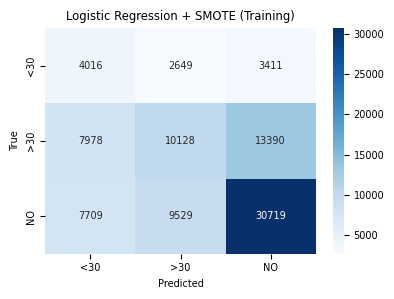

In [159]:
# Confusion matrix for Log Reg + SMOTE
plot_conf_matrix(
    y_train_enc,
    y_pred_log_reg,
    labels=[0,1,2],
    tick_labels=label_encoder.classes_,
    title="Logistic Regression + SMOTE (Training)"
)

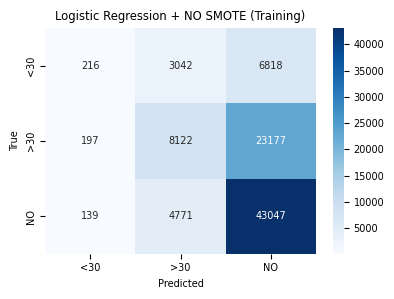

In [160]:
# Confusion matrix for Log Reg + NO SMOTE 
plot_conf_matrix(
    y_train_enc,
    y_pred_log_reg_no_smote,
    labels=[0,1,2],
    tick_labels=label_encoder.classes_,
    title="Logistic Regression + NO SMOTE (Training)"
)


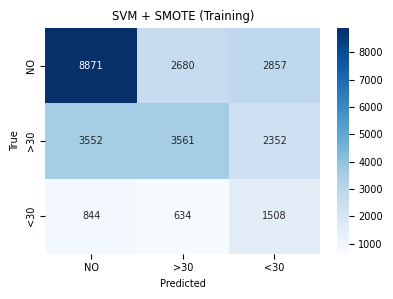

In [161]:
# Confusion matrix for SVM + SMOTE
labels_str = ["NO", ">30", "<30"]

plot_conf_matrix(
    y_train_svm,
    y_train_pred_svm,
    labels_str,
    "SVM + SMOTE (Training)",
    tick_labels=labels_str
)

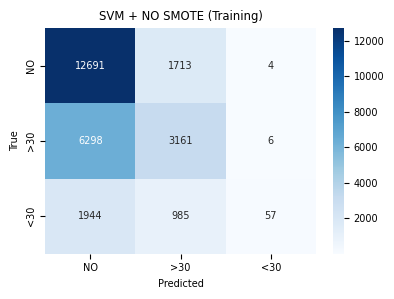

In [162]:
# Confusion matrix for SVM + no smote
labels_str = ["NO", ">30", "<30"]

plot_conf_matrix(
    y_train_svm,
    y_train_pred_svm_no_smote,
    labels_str,
    "SVM + NO SMOTE (Training)",
    tick_labels=labels_str
)

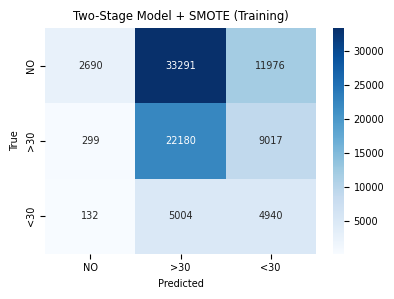

In [ ]:
# Two stage Model + SMOTE
labels_str = ["NO", ">30", "<30"]

plot_conf_matrix(
    y_two_stage,
    final_pred,
    labels=labels_str,
    tick_labels=labels_str,
    title="Two-Stage Model + SMOTE (Training)"
)

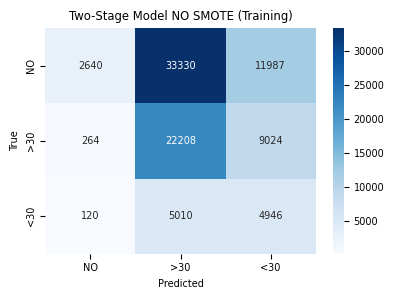

In [165]:
# Two stage Model + SMOT
plot_conf_matrix(
    y_two_stage,
    final_pred_no,
    labels=labels_str,
    tick_labels=labels_str,
    title="Two-Stage Model NO SMOTE (Training)"
)

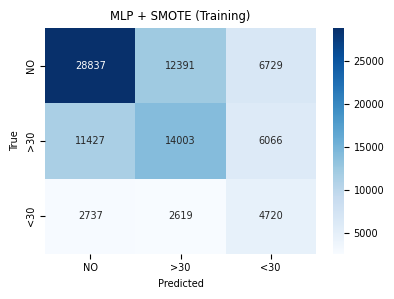

In [ ]:
# tertiary MLP + Smote 
labels_str = ["NO", ">30", "<30"]

plot_conf_matrix(
    y_train_mlp,
    y_train_pred_mlp,
    labels=labels_str,
    tick_labels=labels_str,
    title="MLP + SMOTE (Training)"
)


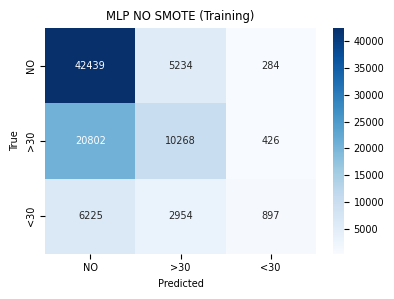

In [ ]:
# tertiary MLP + no smote
plot_conf_matrix(
    y_train_mlp,
    y_train_pred_mlp_no,
    labels=labels_str,
    tick_labels=labels_str,
    title="MLP NO SMOTE (Training)"
)

# 7. Final Predictions on Test Set
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [192]:

# inference of the 3-way logistic regression model
test_df = pd.read_csv(TEST_DATA_FILEPATH)

test_df["age_midpoint"] = test_df["age"].apply(get_age_mid)
test_df = clean_inpatient_data(test_df)
test_df = clean_patient_interaction_cols(test_df)
test_df = standard_cleaning(test_df)

X_test_log_reg = test_df[features]
y_test_log_reg = test_df['readmitted']

y_test_enc = label_encoder.transform(y_test_log_reg)

y_test_pred = log_reg_model.predict(X_test_log_reg)

print("Test Accuracy:", accuracy_score(y_test_enc, y_test_pred))
print(classification_report(
    y_test_enc,
    y_test_pred,
    target_names=label_encoder.classes_
))


Test Accuracy: 0.49282344675298606
              precision    recall  f1-score   support

         <30       0.18      0.37      0.25      1093
         >30       0.45      0.32      0.37      3511
          NO       0.64      0.63      0.64      5359

    accuracy                           0.49      9963
   macro avg       0.42      0.44      0.42      9963
weighted avg       0.52      0.49      0.50      9963



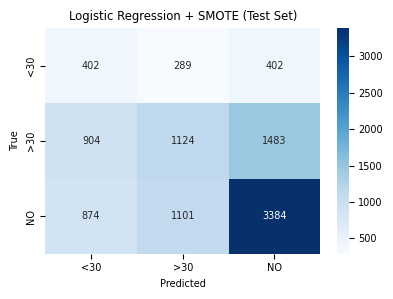

In [ ]:
# confusion matrix for test set log reg
labels_num = [0, 1, 2]
labels_txt = label_encoder.classes_

plot_conf_matrix(
    y_test_enc,
    y_test_pred,
    labels=labels_num,
    tick_labels=labels_txt,
    title="Logistic Regression + SMOTE (Test Set)"
)


In [193]:
# Inference of MLP model on test data (using helper preprocessing)
from sklearn.metrics import accuracy_score, classification_report

# Temporarily reuse helper cleaning on test data
_df_backup = df

test_df = pd.read_csv(TEST_DATA_FILEPATH)

test_df["age_midpoint"] = test_df["age"].apply(get_age_mid)
test_df = clean_inpatient_data(test_df)
test_df = clean_patient_interaction_cols(test_df)
test_df = standard_cleaning(test_df)

test_df_mlp = test_df.copy()

df = _df_backup

X_test_mlp = test_df_mlp[features_mlp]
y_test_mlp = test_df_mlp["readmitted"]

X_test_mlp_proc = mlp_preprocessor.transform(X_test_mlp)
if hasattr(X_test_mlp_proc, "toarray"):
    X_test_mlp_proc = X_test_mlp_proc.toarray()

y_test_pred_mlp = mlp_model.predict(X_test_mlp_proc)

labels_mlp = ["NO", ">30", "<30"]

print("MLP Test Results:")
print("Accuracy:", accuracy_score(y_test_mlp, y_test_pred_mlp))
print(classification_report(
    y_test_mlp,
    y_test_pred_mlp,
    labels=labels_mlp,
    target_names=labels_mlp
))


MLP Test Results:
Accuracy: 0.4879052494228646
              precision    recall  f1-score   support

          NO       0.66      0.58      0.62      5359
         >30       0.44      0.40      0.42      3511
         <30       0.16      0.30      0.21      1093

    accuracy                           0.49      9963
   macro avg       0.42      0.43      0.42      9963
weighted avg       0.53      0.49      0.50      9963



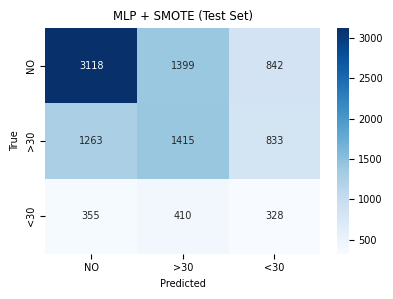

In [194]:
labels_str = ["NO", ">30", "<30"]

plot_conf_matrix(
    y_test_mlp,
    y_test_pred_mlp,
    labels=labels_str,
    tick_labels=labels_str,
    title="MLP + SMOTE (Test Set)"
)
